# Hand-by-hand pytorch implementation: Image Semantic Segmentation
<font size = 4> Example code with VOC-2007 database and self-defineation model </font> <br>

<font size = 4> VOC2007 dataset can be downlad in [offical website](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)
    , you can donwlad [files](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar) directly.
    </font>

<font size=3> The training and validation sets are already defined/separated, and can find the defined file in 
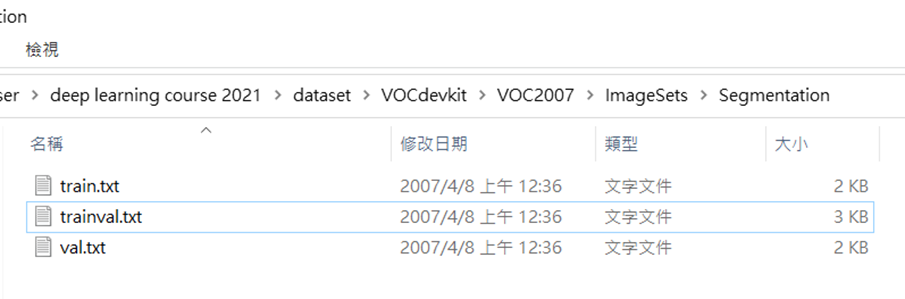

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
from PIL import Image
import json
import torch 
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Segmentation標註檔案在VOC存成圖片的格式

<font size=3> 需要利用PIL來讀取segmentation的標註檔。<br>
    讀取出來內容物為0~20和255共22種。


file: ./dataset/VOCdevkit/VOC2007/SegmentationClass/000129.png
anno: {0, 2, 15, 255}
img info: <PIL.PngImagePlugin.PngImageFile image mode=P size=334x500 at 0x1BB373DA288>
[[255  15  15 ...   0   0   0]
 [255  15  15 ...   0   0   0]
 [255  15  15 ...   0   0   0]
 ...
 [  0   0   0 ...   2   2   2]
 [  0   0   0 ...   2   2   2]
 [  0   0   0 ...   2   2   2]]
(500, 334)


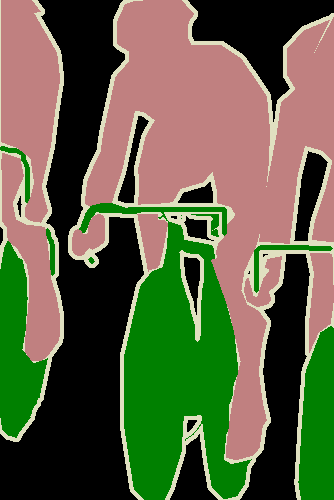

In [2]:
files = [ 
        './dataset/VOCdevkit/VOC2007/SegmentationClass/000129.png',
        ]

for f in files:
    img = Image.open(f)
    annotation = np.array(img)
    print('\nfile: {}\nanno: {}\nimg info: {}'.format(
        f, set(annotation.flatten()), img))
print(annotation)
print(annotation.shape)
img

類別數字對應的結果為 [參考The PASCAL Visual Object Classes Challenge 2012 (VOC2012) Development Kit: 10.2.1 VOCinit](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00060000000000000000) <br>
VOCopts.classes={'aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
                 'chair','cow','diningtable','dog',
                 'horse','motorbike','person','pottedplant',
                 'sheep','sofa','train','tvmonitor'}
                 
 |classname|encode|classname|encode|
 |:---:|:---:|:---:|:---:|
 |飛機(aeroplane)|1| 餐桌(diningtable)|11|
 |自行車(bicycle)|2| 狗(dog)|12|
 |鳥(bird)|3| 馬(horse)|13|
 |船(boat)|4| 摩托車(motorbike)|14|
 |瓶子(bottle)|5| 人(person)|15|
 |公車(bus)|6| 盆栽(pottedplant)|16|
 |汽車(car)|7| 羊(sheep)|17|
 |貓(cat)|8| 沙發(sofa)|18|
 |椅子(chair)|9| 火車(train)|19|
 |牛(cow)|10| 電視機(tvmonitor)|20|
 |背景(background)|0|無效(void)|255|

上圖可以看到圖片有邊邊的部分在VOC用255表示(index 255在VOC歸納到無效類別)，因為邊際的pixel有可能是類別物件也有可能是background，所以我在後續訓練的時候會先歸納成0。

## 資料前處理: 我們先將VOC提供的train.txt和val.txt將圖片路徑取出存放在同一個資料裡面，並儲存成josn檔案方便後續訓練存取用。

In [3]:
def filelist(split, filefolder="./dataset/VOCdevkit/VOC2007/ImageSets/Segmentation/"):
    folder_rawimg = './dataset/VOCdevkit/VOC2007/JPEGImages/'
    folder_labelmap = './dataset/VOCdevkit/VOC2007/SegmentationClass/'
    
    path = os.path.join(filefolder, split + ".txt")
    file_list = tuple(open(path, "r"))
    file_list = [id_.rstrip() for id_ in file_list]
    
    paths_rawimg, paths_labelmap=[],[]
    for tmp_filename in file_list:
        
        path_rawimg = os.path.join(folder_rawimg, tmp_filename+'.jpg')
        path_labelmap = os.path.join(folder_labelmap, tmp_filename+'.png')
        if os.path.isfile(path_rawimg) & os.path.isfile(path_labelmap):
            paths_rawimg.append(path_rawimg)
            paths_labelmap.append(path_labelmap)
    return paths_rawimg, paths_labelmap

paths_rawimg, paths_labelmap = filelist('train', filefolder="./dataset/VOCdevkit/VOC2007/ImageSets/Segmentation/")
data={}
data['paths_img']=paths_rawimg
data['labpaths_labelmapls'] = paths_labelmap
with open('./dataset/database/VOC2007_Seg_train.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)
paths_rawimg, paths_labelmap = filelist('val', filefolder="./dataset/VOCdevkit/VOC2007/ImageSets/Segmentation/")
data={}
data['paths_img']=paths_rawimg
data['labpaths_labelmapls'] = paths_labelmap
with open('./dataset/database/VOC2007_Seg_val.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)



## VOC2007 Dataset dataloader建立
- 我這邊多寫了一個影像旋轉的function，因為圖片經由旋轉後，相對應的label圖片也要進行相同角度的旋轉，所以這個函數是在同時對圖片和label圖片進行同一個角度的旋轉。

In [4]:
class MyRotationTransform:
    """Rotate by one of the given angles."""
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, image, segmentation):
        image = TF.rotate(image, self.angle)
        segmentation = TF.rotate(segmentation, self.angle)
        return image, segmentation

class VOCDataset2007_Seg(torch.utils.data.Dataset):
    '''
    load the dataset
    '''
    def __init__(self,
                 img_size=224,
                 split='train', 
                 flag_dataaug=1):
        jsonpath = './dataset/database/VOC2007_Seg_' + split +'.json'
        with open(jsonpath) as jsonfile:
            data_load = json.load(jsonfile)
        self.imList = data_load['paths_img']
        self.labelList = data_load['labpaths_labelmapls']
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.flag_dataaug=flag_dataaug
        self.tf = transforms.Compose(
                                    [   transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])    
        
        print('number of total data:{}'.format(len(self.imList)))
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_path = self.imList[idx]
        labelmap_path = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_path, mode='r')
        image = image.convert('RGB')
        # read segmentation label
        labelmap = Image.open(labelmap_path)
        
        
        image = image.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        labelmap = labelmap.resize((self.img_size[0], self.img_size[1]))
        
        
        if self.flag_dataaug==1:
            if random.random() < 0.3:
                image, labelmap = MyRotationTransform(angle = random.randint(-180, 180))(image, labelmap)
                             
        # Convert PIL label image to torch.Tensor
        image = self.tf(image)
        labelmap = torch.from_numpy(np.array(labelmap)).long()
        labelmap[labelmap == 255] = 0

        return image, labelmap
    
    
dataset_train = VOCDataset2007_Seg(split='train', flag_dataaug=1)    
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2)
for i, data in enumerate(dataloader_train):
    imgs, labelmaps = data
    print(imgs.shape)
    print(labelmaps.shape)
    break
      

number of total data:209
torch.Size([2, 3, 224, 224])
torch.Size([2, 224, 224])


## 我這邊建立一個非常簡易的UNET模型，channel數量也少一點。
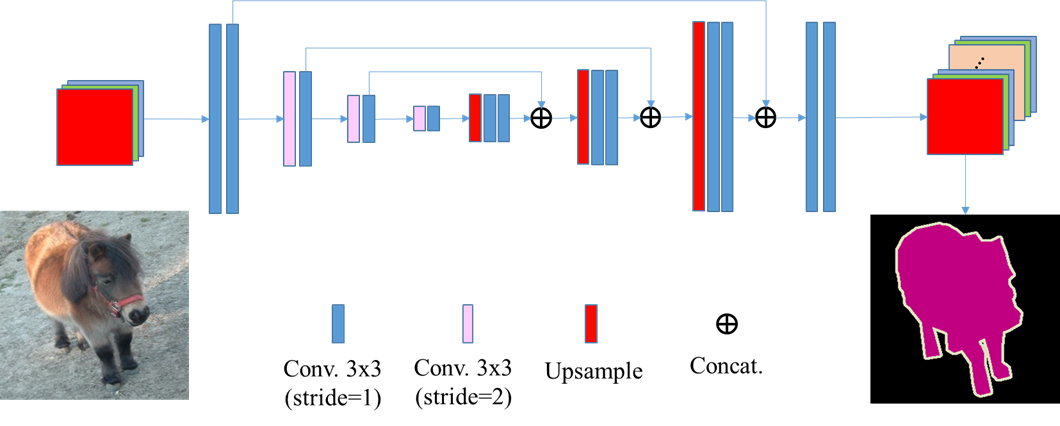

In [5]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, stride=1, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride = 1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.triple_conv(x)

    
class mytinyUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(mytinyUNet, self).__init__()
    
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 64,stride=2)
        self.down2 = DoubleConv(64, 128,stride=2)
        self.down3 = DoubleConv(128, 256,stride=2)
        
        self.up1 = DoubleConv(256, 128)
        self.up2 = DoubleConv(256, 64)
        self.up3 = DoubleConv(128, 64)
        self.outfusion = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x4 = self.up(x4)
        x = self.up1(x4)
        x = torch.cat([x3, x], dim=1)
                
        x = self.up(x)
        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        
        x = self.up(x)
        x = self.up3(x)
        x = torch.cat([x1, x], dim=1)
        x = self.outfusion(x)
        logits = self.outc(x)
        return logits
    
model = mytinyUNet(n_channels=3, n_classes=21)    
dummy_inpurt = torch.rand(1,3,224,224)
out=model(dummy_inpurt)
torch.onnx.export(model, dummy_inpurt, './mytinyUNet.onnx', opset_version=11, example_outputs=out)

# 訓練流程
步驟0. 是否使用CUDA <br>
步驟1. data loader處理 <br>
步驟2. 模型宣告 <br>
步驟3. loss function宣告 <br>
步驟4. optimator宣告 <br>
步驟5. 模型開始訓練 <br>

In [6]:
import torch
import torchvision.models as models
# models.segmentation.fcn_resnet50(num_classes=20)
use_cuda = 1
milestones = [50, 100, 150, 200]
batch_size = 4
img_size = 224
# 步驟0. 是否使用CUDA 
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)


# 步驟1. data loader處理 
dataset_train = VOCDataset2007_Seg(img_size=img_size, split='train', flag_dataaug=1)    
dataset_val   = VOCDataset2007_Seg(img_size=img_size, split='val',   flag_dataaug=0)    
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val   = torch.utils.data.DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)

# 步驟3. loss function宣告
criterion = torch.nn.CrossEntropyLoss().to(device)

# 步驟2. 模型宣告 (VOC類別為20 + 1(background))
# training from scratch
model = mytinyUNet(n_channels=3, n_classes=21).to(device)    
# model fine-tuning (transfer learning): 這邊我們用ˋ一個內建的FCN(Backbone是ResNet50)
model_TL = models.segmentation.fcn_resnet50(pretrained=True,num_classes=21).to(device)  

# 步驟4. optimator和scheduler宣告
def exp(model,lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    return optimizer, scheduler

cuda
number of total data:209
number of total data:213


In [7]:
def evalmodel(model, dataloader, criterion):
    model.eval()
    lossvalue = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            if isinstance(output,dict):
                output = output['out']
        lossvalue += criterion(output, target)  
    lossvalue /= len(dataloader.dataset)
    return lossvalue

def trainmodel(model, dataloader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if isinstance(output,dict):
            output = output['out']
        loss = criterion(output,target)  
        loss.backward()
        optimizer.step()

def train(model, optimizer, dataloader_train, dataloader_val, criterion, scheduler, total_epoch):
    # 步驟5. CNN模型開始訓練
    log_loss_train=[]
    log_loss_val=[]
    for epoch in range(total_epoch):
        # train
        trainmodel(model, dataloader_train, optimizer, criterion)
        scheduler.step()
        # eval
        if (epoch % 5 == 0) | (epoch == (total_epoch-1)):
            val_loss = evalmodel(model, dataloader_val, criterion)
            log_loss_val.append([epoch,val_loss.detach().cpu().numpy()])
            
            print('\n learning rate:{}'.format(scheduler.get_last_lr()[0]))
            print('CNN[epoch: [{}/{}], loss(val):{:.5f}'.format(
                epoch+1, total_epoch, val_loss))                    
    print('training done.')
    return log_loss_val

# Training model from scratch with Self-defined UNet


 learning rate:0.01
CNN[epoch: [1/100], loss(val):0.37128

 learning rate:0.01
CNN[epoch: [6/100], loss(val):0.33186

 learning rate:0.01
CNN[epoch: [11/100], loss(val):0.33946

 learning rate:0.01
CNN[epoch: [16/100], loss(val):0.31664

 learning rate:0.01
CNN[epoch: [21/100], loss(val):0.31145

 learning rate:0.01
CNN[epoch: [26/100], loss(val):0.31089

 learning rate:0.01
CNN[epoch: [31/100], loss(val):0.31395

 learning rate:0.01
CNN[epoch: [36/100], loss(val):0.32859

 learning rate:0.01
CNN[epoch: [41/100], loss(val):0.30587

 learning rate:0.01
CNN[epoch: [46/100], loss(val):0.29887

 learning rate:0.001
CNN[epoch: [51/100], loss(val):0.29923

 learning rate:0.001
CNN[epoch: [56/100], loss(val):0.29945

 learning rate:0.001
CNN[epoch: [61/100], loss(val):0.29952

 learning rate:0.001
CNN[epoch: [66/100], loss(val):0.29992

 learning rate:0.001
CNN[epoch: [71/100], loss(val):0.30151

 learning rate:0.001
CNN[epoch: [76/100], loss(val):0.29943

 learning rate:0.001
CNN[epoch: [81

Text(0.5, 1.0, 'Val (training from scratch)')

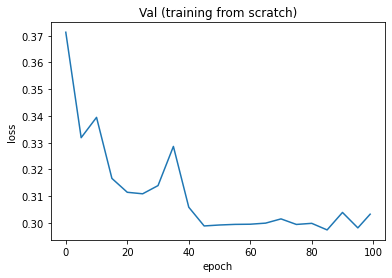

In [8]:
# 步驟5. 模型開始訓練
# training from scratch
optimizer, scheduler = exp(model,lr=0.01)  
loss_val_scratch = train(model, 
                        optimizer,
                        dataloader_train, 
                        dataloader_val, 
                        criterion, 
                        scheduler,
                        total_epoch=100)
torch.save(model,'model_seg_scratch.pt')

loss_val_scratch=np.array(loss_val_scratch)

plt.figure()
plt.plot(loss_val_scratch[:,0],loss_val_scratch[:,1])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Val (training from scratch)')

# Training model by transfer learning with FCN(ResNet50)
因為是fine-tuning所以學習次數不用太多，我設定10個epoch，learning rate也不用太大，我設定為0.0001。

In [9]:
# 步驟5. 模型開始訓練
# model fine-tuning (transfer learning)
optimizer_TL, scheduler_TL = exp(model_TL,lr=0.0001)
loss_val_TL = train(model_TL, 
                    optimizer_TL,
                    dataloader_train, 
                    dataloader_val, 
                    criterion, 
                    scheduler_TL,
                    total_epoch=10)
torch.save(model_TL,'model_seg_TL.pt')


 learning rate:0.0001
CNN[epoch: [1/10], loss(val):0.08867

 learning rate:0.0001
CNN[epoch: [6/10], loss(val):0.08146

 learning rate:0.0001
CNN[epoch: [10/10], loss(val):0.07922
training done.


# Inference by single image one by one


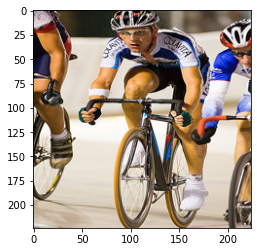

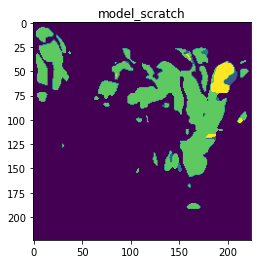

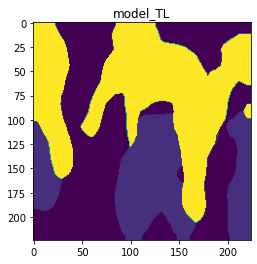

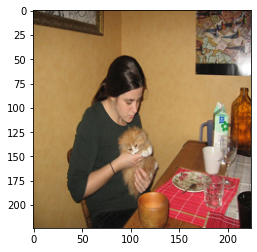

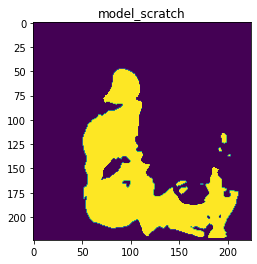

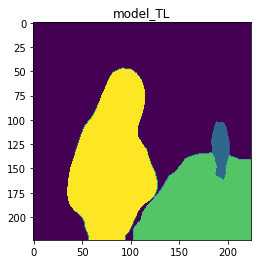

In [11]:
mytransforms = transforms.Compose(
            [   transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])    

image_paths =['./dataset/VOCdevkit/VOC2007/JPEGImages/000129.jpg',
            './dataset/VOCdevkit/VOC2007/JPEGImages/001185.jpg']

for image_path in image_paths:
    image = Image.open(image_path, mode='r')
    image = image.convert('RGB')

    plt.figure()
    plt.imshow(image.resize((img_size,img_size)))    
    plt.show()

    image = image.resize((img_size,img_size))  # uint8 with RGB mode
    image = mytransforms(image)

    image = torch.unsqueeze(image,dim=0)
    image=image.to(device)

    model.eval()
    output = model(image)
    output_index = output.argmax(dim=1)
    output_index=output_index.squeeze()
    output_index = output_index.detach().cpu().numpy()
    plt.imshow(output_index)
    plt.title('model_scratch')
    plt.show()

    model_TL.eval()
    output_TL = model_TL(image)
    output_TL = output_TL['out']
    output_index = output_TL.argmax(dim=1)
    output_index = output_index.squeeze()
    output_index = output_index.detach().cpu().numpy()
    plt.imshow(output_index)
    plt.title('model_TL')
    plt.show()

## 小結論: 
<font size=4> 
    模型從頭訓練的結果很差，原因是我們的訓練資料只有2百多筆，但模型參數非常的多，我們用很少的數據要去訓練大模型，本身就非常困難，所以Deep learning被歸納在需要大數據才能訓練的模型。<br><br>
    假設我們有一個三元一次的方程式:
    $$
    a_1 \times x_1 + a_2 \times x_2 + a_3 \times x_3 = 0
    $$
    <br>但我只有兩筆數據: <br>
    $$X_1=[x_1,x_2,x_3]=[1,2,3] 和 X_2=[x_1,x_2,x_3]=[4,5,6]$$
    
這時候聯立解會有無窮多組，所以DL/ML就是在loss函數上去找近似解，所以找到的不一定是最合適的，因為找到的只會盡量去fit訓練資料，也有可能根本訓練不起來。<br><br>
    </font> 
    
    
<font size=4>**模型訓練的解決方法:**<br>
    - 1. 用非常大的數據來訓練。<br>
    - 2. Backbone有先用ImageNet訓練過。<br>
    - 3. 直接拿別人訓練好的模型來fine-tune。<br><br>
 </font> 
<font size=4 color='red'> 
**所以為什麼大部分的人常常直接用別人的模型，因為我們的資料量通常不太夠，別人的模型通常有訓練好的權重我們可以直接用來fine-tune。**<br>    
 </font> 

<font size=4> 
Note: Few-shot learning是例外，用來解決需要大數據的問題，實際上還是需要很多樣本才能跑，只是他是利用多小樣本之間屬性不同的方式來進行學習。
 </font> 


------------------------------------------------
# 假設模型我訓練好了，我用讀之前訓練的模型和權重出來用就好

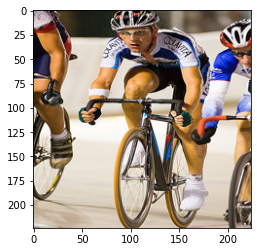

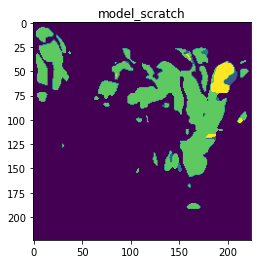

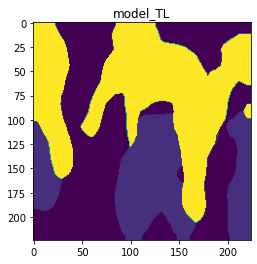

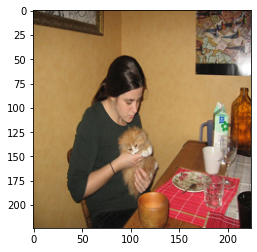

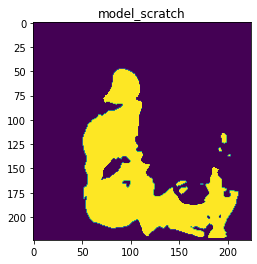

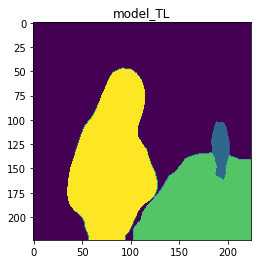

In [13]:

model_TL_2 = torch.load('model_seg_TL.pt')
model_2 = torch.load('model_seg_scratch.pt')


mytransforms = transforms.Compose(
            [   transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])    

image_paths =['./dataset/VOCdevkit/VOC2007/JPEGImages/000129.jpg',
            './dataset/VOCdevkit/VOC2007/JPEGImages/001185.jpg']

for image_path in image_paths:
    image = Image.open(image_path, mode='r')
    image = image.convert('RGB')

    plt.figure()
    plt.imshow(image.resize((img_size,img_size)))    
    plt.show()

    image = image.resize((img_size,img_size))  # uint8 with RGB mode
    image = mytransforms(image)
    image = torch.unsqueeze(image,dim=0)
    image = image.to(device)

    model_2.eval()
    output = model_2(image)
    output_index = output.argmax(dim=1)
    output_index=output_index.squeeze()
    output_index = output_index.detach().cpu().numpy()
    plt.imshow(output_index)
    plt.title('model_scratch')
    plt.show()

    model_TL_2.eval()
    output_TL = model_TL_2(image)
    output_TL = output_TL['out']
    output_index = output_TL.argmax(dim=1)
    output_index = output_index.squeeze()
    output_index = output_index.detach().cpu().numpy()
    plt.imshow(output_index)
    plt.title('model_TL')
    plt.show()

<font size = 4>
有些人跑上述程式應該會出錯，實際上坑很多
因為我是用GPU訓練，如果你電腦沒有GPU這樣的存取方式應該會出錯